In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-07-18T19:53:49.217862+03:00

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [3]:
import os
import pickle as pkl
#import tqdm

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from sklearn import preprocessing
import lightgbm as lgb

from itertools import product

In [4]:
from tqdm.auto import tqdm
tqdm.pandas()

In [5]:
#from catboost import __version__ as cb_version
from sklearn import __version__ as sklearn_version

#print(f'cb_version: {cb_version}')
print(f'sklearn_version: {sklearn_version}')

sklearn_version: 0.24.2


In [6]:
%watermark --iversions

pandas  : 0.25.3
lightgbm: 3.3.2
sklearn : 0.24.2
numpy   : 1.20.3



## Reproducibility block

In [7]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

CB_RANDOMSEED  = 309487
XGB_RANDOMSEED = 56
LGB_RANDOMSEED = 874256

In [8]:
DIR_DATA   = os.path.join(os.getcwd(), 'data')
DIR_MODELS = os.path.join(os.getcwd(), 'models')
DIR_SUBM   = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_PART = os.path.join(os.getcwd(), 'subm', 'partial')

In [9]:
NTRY = 14
NAME = f'{NTRY}_lgb_pca64_sber_lags_parse_bord_nose'

In [10]:
CTR_UKR = 6.096

VIEWS_UKR = 2554204
DEPTH_UKR = 1.799
FPR_UKR = 4.978

## Load data

In [11]:
df_train = pd.read_csv(os.path.join(DIR_DATA, 'train_upd.csv'))#, index_col= 0)
x_train  = pd.read_csv(os.path.join(DIR_DATA, 'x_train.csv'))#, index_col= 0)
x_val    = pd.read_csv(os.path.join(DIR_DATA, 'x_val.csv'))#, index_col= 0)
df_test  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'))#, index_col= 0)

with open(os.path.join(DIR_DATA, 'cat_columns.pkl'), 'rb') as pickle_file:
    cat_cols = pkl.load(pickle_file)
    
with open(os.path.join(DIR_DATA, 'num_columns.pkl'), 'rb') as pickle_file:
    num_cols = pkl.load(pickle_file)

with open(os.path.join(DIR_DATA, 'clmns.pkl'), 'rb') as pickle_file:
    clmns = pkl.load(pickle_file)

In [12]:
df_train.shape, df_test.shape, len(cat_cols), len(num_cols), #x_train.shape, x_val.shape,

((6981, 291), (3000, 287), 11, 262)

отделяем метки от данных

In [13]:
y_train = x_train[['views', 'depth', 'full_reads_percent']]
x_train.drop(['views', 'depth', 'full_reads_percent'], axis = 1, inplace = True)

y_val = x_val[['views', 'depth', 'full_reads_percent']]
x_val.drop(['views', 'depth', 'full_reads_percent'], axis = 1, inplace = True)

In [14]:
#cat_cols + num_cols

In [15]:
cat_cols = cat_cols + ['category']

In [16]:
df_train['category'] = df_train['category'].astype('category')
x_train['category']  = x_train['category'].astype('category')
x_val['category']    = x_val['category'].astype('category')
df_test['category']  = df_test['category'].astype('category')

In [17]:
#for el in num_cols:
#    print(el)

In [18]:
cat_cols = []
num_cols = []

for el in clmns.keys():
    cat_cols.extend(clmns[el]['cat'])
    num_cols.extend(clmns[el]['num'])
    if len(clmns[el]['both']) != 0:
        print(clmns[el]['both'])

['ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr']
['hour', 'dow', 'day', 'mounth', 'holiday', 'day_before_holiday', 'day_after_holiday', 'distrib_brdr']


In [19]:
num_cols.extend(['hour', 'mounth'])
cat_cols.extend([ 'dow',
                'ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr',
                 'holiday', 'day_before_holiday', 'day_after_holiday', 'distrib_brdr',
                 #'spec_event_1',
                ])

In [20]:
def train_lgb_cat(inp_df, inp_vals, inp_category, inp_cat_cols, inp_num_cols):

    
    num_of_leaves_vars    = [4, 8, 16, 32, 64, 128]
    max_depth_vars        = [4, 8, 16, 32]#, 64, 128]
    min_data_in_leaf_vars = [4, 8, 16, 32]#, 64, 128]
    learn_rate_vars       = [0.1, 0.05, 0.01] #1, 0.5, 
    
    min_rmse = 1000000
    ret_progress = []
    
    for nl, lr, md, mdlf in tqdm(product(num_of_leaves_vars, learn_rate_vars, max_depth_vars, min_data_in_leaf_vars), 
                                total = len(num_of_leaves_vars)*len(learn_rate_vars)*len(max_depth_vars)*len(min_data_in_leaf_vars)
                                ):
    
        params = {
            'task': 'train', 
            'boosting': 'gbdt',
            'objective': 'regression',
            'num_leaves': nl,
            'learning_rate': lr,
            'max_depth': md,
            'min_data_in_leaf': mdlf,
            'metric': {'rmse'},
            #'verbose': -1,
            'random_seed': LGB_RANDOMSEED,
            'force_col_wise': False,
            'n_jobs' : -1,
            
            
            #'reg_alpha': 10,   # != 0  Hard L1 regularization
            #'reg_lambda': 0,   # != 0  Hard L2 regularization
        }


        train_ds_views = lgb.Dataset(inp_df[inp_df.category == inp_category][cat_cols + num_cols],
                                     #inp_df[cat_cols + num_cols],
                                     inp_vals[inp_df.category == inp_category][['views']],
                                     #feature_name = [cat_cols + num_cols]
                                    )

        results = lgb.cv(params, 
                         train_ds_views, 
                         num_boost_round = 10000,
                         nfold = 5,
                         verbose_eval = 500,
                         early_stopping_rounds = 100,
                         stratified = False,
                         #return_cvbooster = True,
                        )

        optimal_rounds = np.argmin(results['rmse-mean'])
        best_cv_score  = min(results['rmse-mean'])

        if best_cv_score < min_rmse:
            ret_progress.append(f'nl={nl:3d}, lr={lr:3f}, md={md:3d}, mdlf={mdlf:3d}, {optimal_rounds}, {best_cv_score}')
        
        #print(nl, lr, md, mdlf, optimal_rounds, best_cv_score)
        print(f'nl={nl:3d}, lr={lr:3f}, md={md:3d}, mdlf={mdlf:3d}, {optimal_rounds}, {best_cv_score}')  
    
    return ret_progress

In [21]:
#progress = train_lgb_cat(df_train, y_train, '5409f11ce063da9c8b588a12', cat_cols, num_cols)

In [22]:
#with open(os.path.join(DIR_DATA, 'progress.pkl'), 'wb') as pickle_file:
#    pkl.dump(progress, pickle_file)

In [23]:
#lgb_train = lgb.Dataset(x_train, y_train)
#lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

#views
train_ds_views = lgb.Dataset(x_train[cat_cols + num_cols],
                             y_train[['views']],
                             #feature_name = [cat_cols + num_cols]
                            )
val_ds_views = lgb.Dataset(x_val[cat_cols + num_cols],
                             y_val[['views']],
                             #feature_name = [cat_cols + num_cols]
                            )

train_views_full = lgb.Dataset(df_train[cat_cols + num_cols],
                             df_train[['views']],
                             #feature_name = [cat_cols + num_cols]
                            )
#!!!!!!!!!!!!!!!!!!!!!!! #lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)


#depth
train_ds_depth = lgb.Dataset(x_train[cat_cols + num_cols],
                             y_train[['depth']],
                             #feature_name = [cat_cols + num_cols]
                            )
val_ds_depth = lgb.Dataset(x_val[cat_cols + num_cols],
                             y_val[['depth']],
                             #feature_name = [cat_cols + num_cols]
                            )
train_depth_full = lgb.Dataset(df_train[cat_cols + num_cols],
                             df_train[['depth']],
                             #feature_name = [cat_cols + num_cols]
                            )


#train_ds_frp
#val_ds_frp

## views

In [24]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 6,
    'learning_rate': 0.05,
    #'metric': {'l2','l1'},
    'metric': {'rmse'},
    'verbose': -1,
    
    #'reg_alpha': 5,   # != 0  Hard L1 regularization
    #'reg_lambda': 10,   # != 0  Hard L2 regularization
    
    #'lambda_l1': 5, 
    #'lambda_l2': 5,
    
    'random_seed': LGB_RANDOMSEED,
}

In [25]:
score = lgb.cv(params, 
                 train_views_full, 
                 num_boost_round = 10000,
                 nfold = 5,
                 verbose_eval = 500,
                 early_stopping_rounds = 100,
                 stratified = False,
                 #return_cvbooster = True,
                )
print(np.argmin(score['rmse-mean']), score['rmse-mean'][np.argmin(score['rmse-mean'])], score['rmse-stdv'][np.argmin(score['rmse-mean'])], )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	cv_agg's rmse: 46676 + 12161.9
510 46645.754055212965 12177.314539607522


In [26]:
# fitting the model
lgb_model_views = lgb.train(params,
                            train_set=train_ds_views,
                            valid_sets=val_ds_views,
                            early_stopping_rounds=30,
                            verbose_eval = False,
                           )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


In [27]:
# Get predictions and metrics
preds_train_views = lgb_model_views.predict(x_train[cat_cols + num_cols])
preds_val_views   = lgb_model_views.predict(x_val[cat_cols + num_cols])

train_score_views = r2_score(y_train["views"], preds_train_views)
val_score_views   = r2_score(y_val["views"],   preds_val_views)

train_score_views, val_score_views

(0.5243921699958027, 0.43827711142405346)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

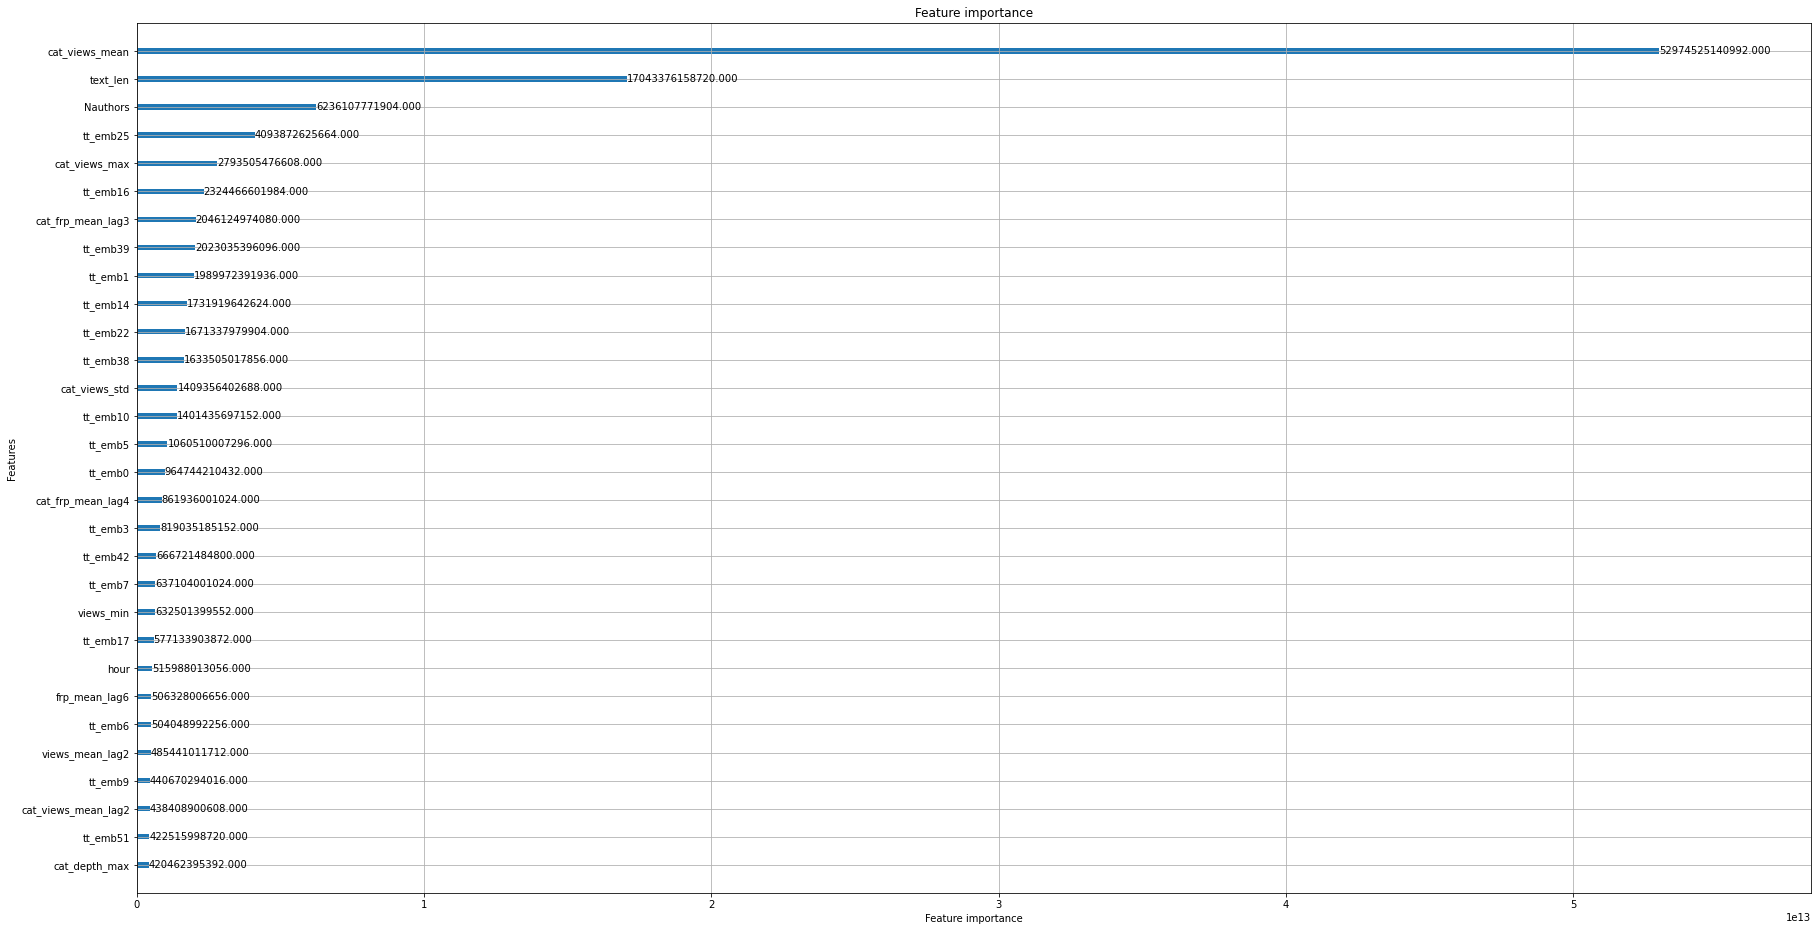

In [28]:
lgb.plot_importance(lgb_model_views, max_num_features = 30, figsize = (30, 16), importance_type = 'gain')
#lgb.plot_importance(lgb_model_views, max_num_features = 30, figsize = (30, 16), importance_type = 'split')
# importance_type (str, optional (default="auto")) – How the importance is calculated. If “auto”, if booster parameter is LGBMModel, booster.importance_type attribute is used; 
# “split” otherwise. If “split”, result contains numbers of times the feature is used in a model. If “gain”, result contains total gains of splits which use the feature.

## depth

In [29]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    #'learning_rate': 0.05,
    #'metric': {'l2','l1'},
    'metric': {'rmse'},
    'verbose': -1,
    
    #'reg_alpha': 5,   # != 0  Hard L1 regularization
    #'reg_lambda': 10,   # != 0  Hard L2 regularization
    
    #'lambda_l1': 5, 
    #'lambda_l2': 5,
    
    'random_seed': LGB_RANDOMSEED,
}

In [30]:
score = lgb.cv(params, 
                 train_depth_full, 
                 num_boost_round = 10000,
                 nfold = 5,
                 verbose_eval = 500,
                 early_stopping_rounds = 100,
                 stratified = False,
                 #return_cvbooster = True,
                )
print(np.argmin(score['rmse-mean']), score['rmse-mean'][np.argmin(score['rmse-mean'])], score['rmse-stdv'][np.argmin(score['rmse-mean'])], )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


298 0.026733251399604675 0.0018038337229047009


In [31]:
# fitting the model
lgb_model_depth = lgb.train(params,
                            train_set=train_ds_depth,
                            valid_sets=val_ds_depth,
                            early_stopping_rounds=30,
                            verbose_eval = False,
                           )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


In [32]:
# Get predictions and metrics
preds_train_depth = lgb_model_depth.predict(x_train[cat_cols + num_cols])
preds_val_depth   = lgb_model_depth.predict(x_val[cat_cols + num_cols])

train_score_depth = r2_score(y_train["depth"], preds_train_depth)
val_score_depth   = r2_score(y_val["depth"],   preds_val_depth)

train_score_depth, val_score_depth

(0.8466513464664916, 0.8019178917699566)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

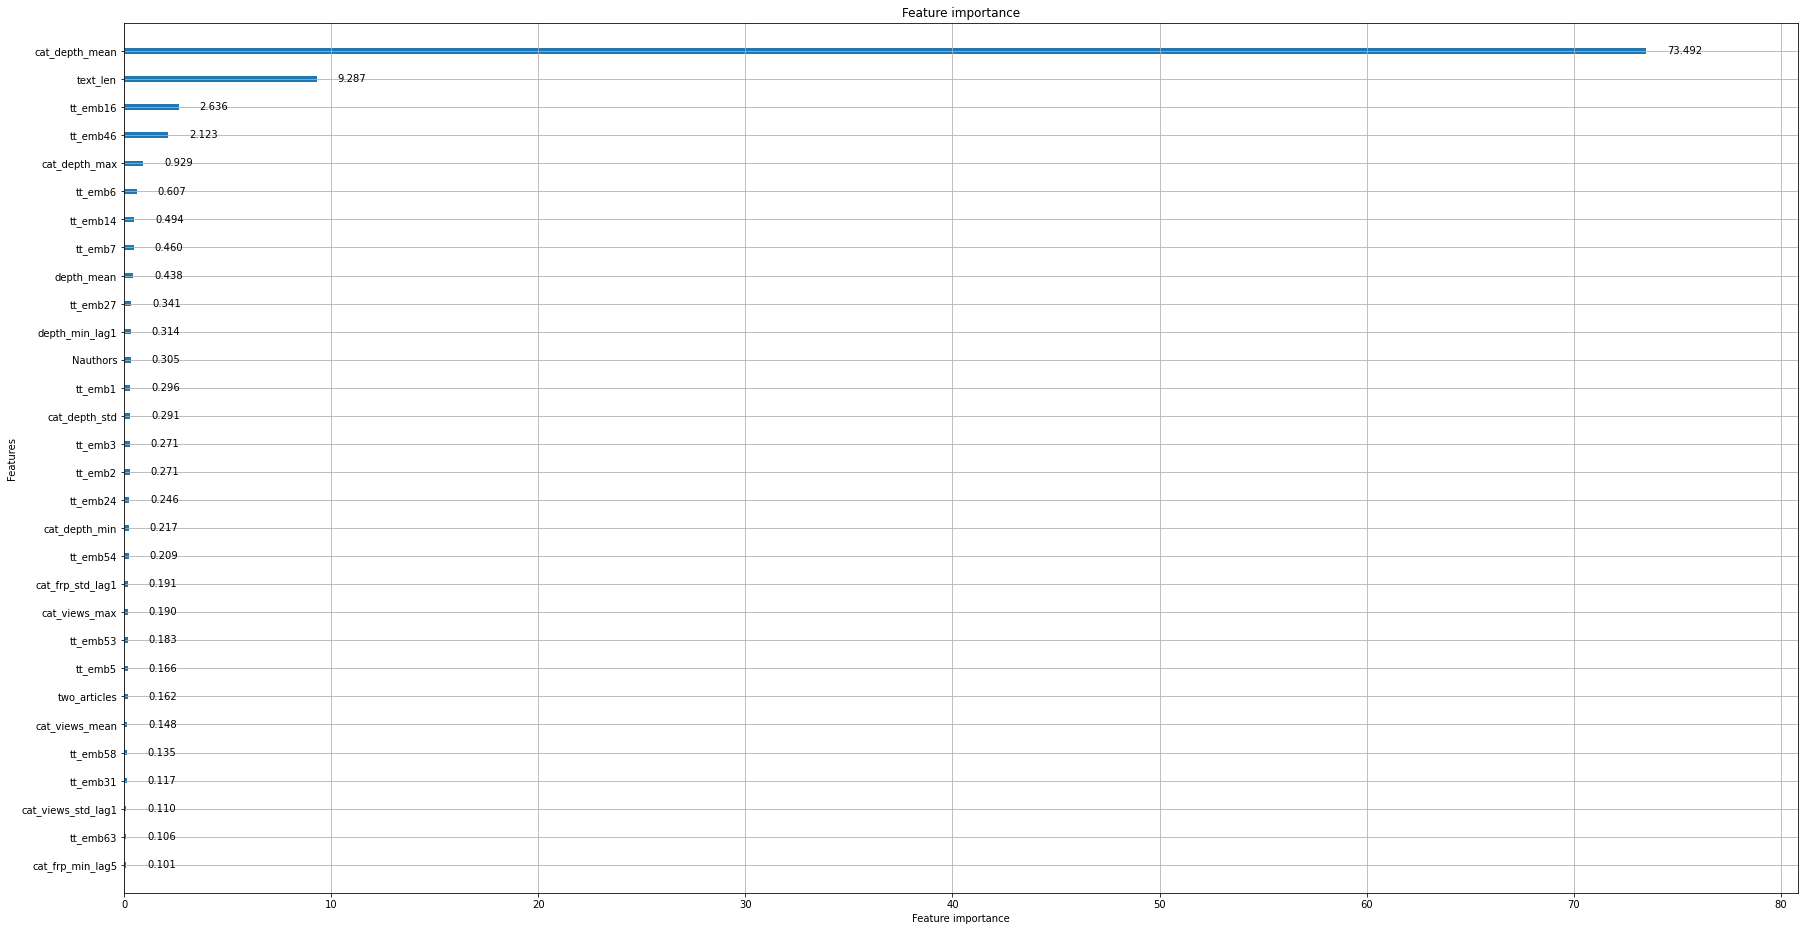

In [33]:
lgb.plot_importance(lgb_model_depth, max_num_features = 30, figsize = (30, 16), importance_type = 'gain')
#lgb.plot_importance(lgb_model_depth, max_num_features = 30, figsize = (30, 16), importance_type = 'split')

## full_reads_percent

In [34]:
#pd.DataFrame(preds_train_depth, columns = ['depth_pred'])
pred_scaler = preprocessing.StandardScaler()
tmp = pred_scaler.fit_transform(preds_train_depth.reshape(-1, 1))
pred_depth_train = pd.DataFrame(tmp, columns = ['depth_pred'])

pred_depth_val   = pd.DataFrame(pred_scaler.transform(preds_val_depth.reshape(-1, 1)), columns = ['depth_pred'])


In [35]:
#x_train.drop(['depth_pred'], axis = 1, inplace = True)

In [36]:
#full_reads_percent
#train_ds_frp = lgb.Dataset(x_train[cat_cols + num_cols + ['depth_pred']],
train_ds_frp = lgb.Dataset(x_train[cat_cols + num_cols],
                             y_train[['full_reads_percent']],
                             #feature_name = [cat_cols + num_cols]
                            )
#val_ds_frp = lgb.Dataset(x_val[cat_cols + num_cols + ['depth_pred']],
val_ds_frp = lgb.Dataset(x_val[cat_cols + num_cols],
                             y_val[['full_reads_percent']],
                             #feature_name = [cat_cols + num_cols]
                            )

train_frp_full = lgb.Dataset(df_train[cat_cols + num_cols],
                             df_train[['full_reads_percent']],
                             #feature_name = [cat_cols + num_cols]
                            )

In [37]:
score = lgb.cv(params, 
                 train_frp_full, 
                 num_boost_round = 10000,
                 nfold = 5,
                 verbose_eval = 500,
                 early_stopping_rounds = 100,
                 stratified = False,
                 #return_cvbooster = True,
                )
print(np.argmin(score['rmse-mean']), score['rmse-mean'][np.argmin(score['rmse-mean'])], score['rmse-stdv'][np.argmin(score['rmse-mean'])], )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


102 7.006915546041529 0.09111757568475078


In [38]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    #'learning_rate': 0.05,
    #'metric': {'l2','l1'},
    'metric': {'rmse'},
    'verbose': -1,
    
    #'reg_alpha': 5,   # != 0  Hard L1 regularization
    #'reg_lambda': 10,   # != 0  Hard L2 regularization
    
    #'lambda_l1': 5, 
    #'lambda_l2': 5,
    
    'random_seed': LGB_RANDOMSEED,
}

In [39]:
# fitting the model
lgb_model_frp = lgb.train(params,
                            train_set=train_ds_frp,
                            valid_sets=val_ds_frp,
                            early_stopping_rounds=30,
                            verbose_eval = False,
                           )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


In [40]:
# Get predictions and metrics
#preds_train_frp = lgb_model_frp.predict(x_train[cat_cols + num_cols + ['depth_pred']])
#preds_val_frp   = lgb_model_frp.predict(x_val[cat_cols + num_cols + ['depth_pred']])

preds_train_frp = lgb_model_frp.predict(x_train[cat_cols + num_cols])
preds_val_frp   = lgb_model_frp.predict(x_val[cat_cols + num_cols])


train_score_frp = r2_score(y_train["full_reads_percent"], preds_train_frp)
val_score_frp   = r2_score(y_val["full_reads_percent"],   preds_val_frp)

train_score_frp, val_score_frp

(0.650261301389814, 0.5441183141206988)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

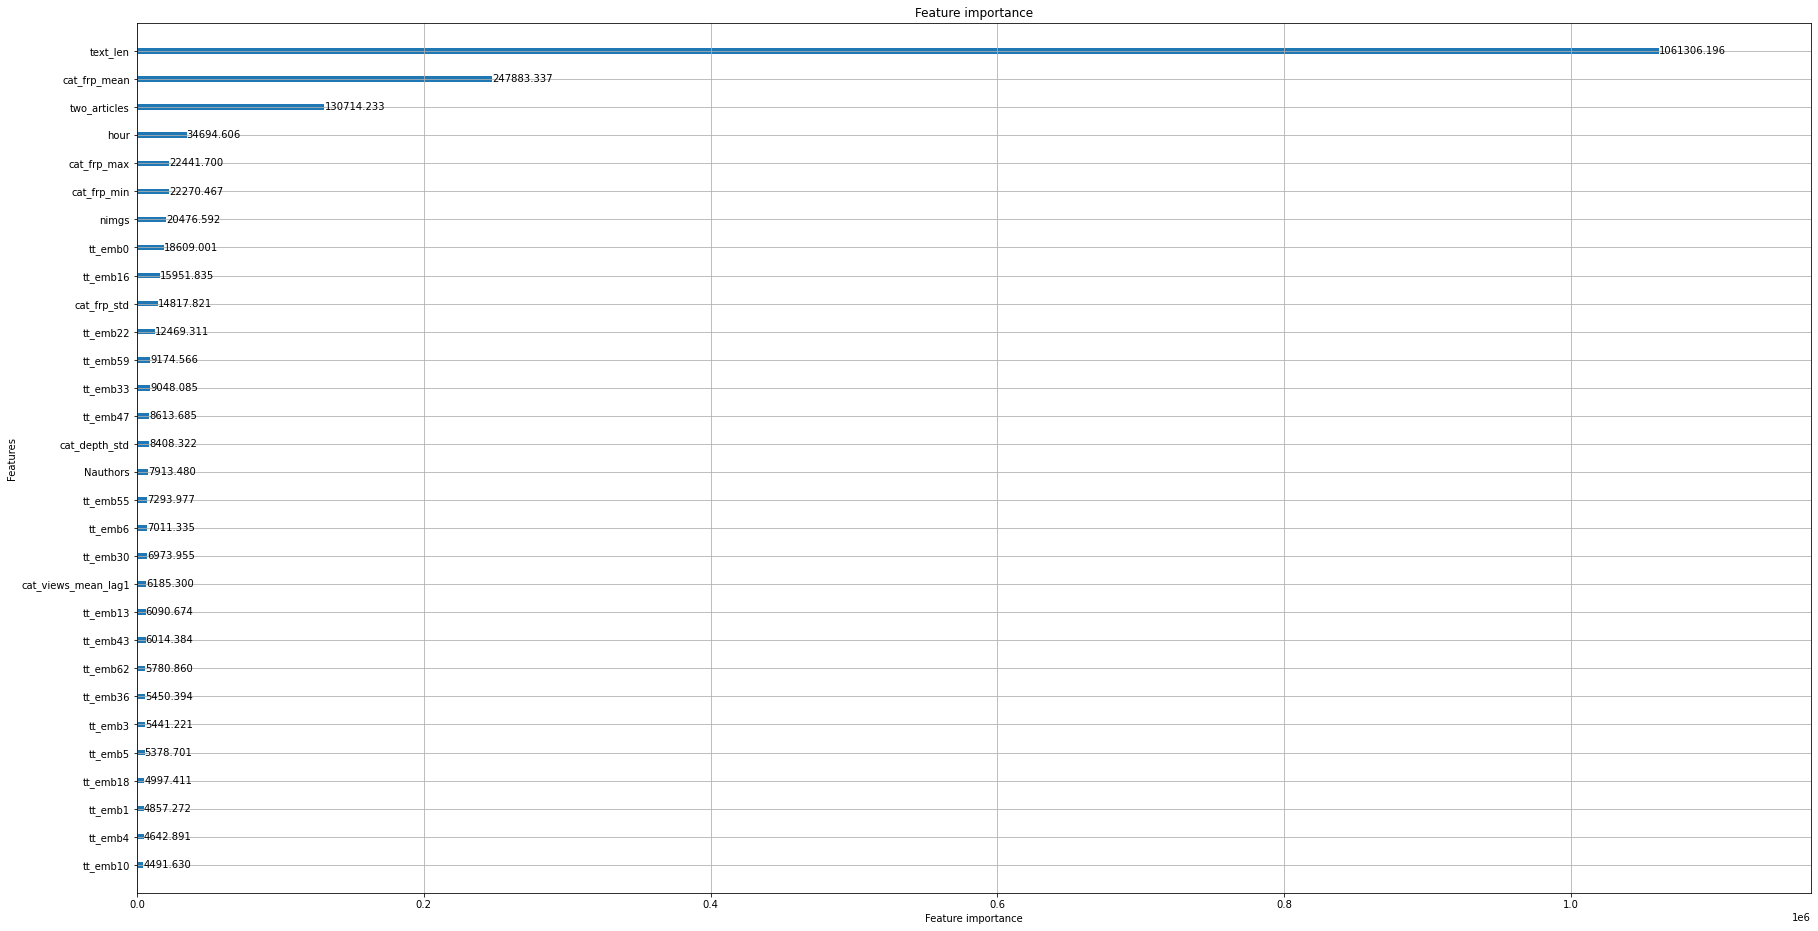

In [41]:
lgb.plot_importance(lgb_model_frp, max_num_features = 30, figsize = (30, 16), importance_type = 'gain')
#lgb.plot_importance(lgb_model_frp, max_num_features = 30, figsize = (30, 16), importance_type = 'split')

In [42]:
score_train = 0.4 * train_score_views + 0.3 * train_score_depth + 0.3 * train_score_frp
score_val  = 0.4 * val_score_views  + 0.3 * val_score_depth  + 0.3 * val_score_frp

score_train, score_val

(0.6588306623552127, 0.579121706336818)

# Сохраняем предсказания для ансамблей / стекинга

In [43]:
x_train_pred = x_train[['document_id']]
x_val_pred   = x_val[['document_id']]

print('before ', x_train_pred.shape, preds_train_views.shape, preds_train_depth.shape, preds_train_frp.shape)
print('before ', x_val_pred.shape,   preds_val_views.shape,   preds_val_depth.shape,   preds_val_frp.shape)

# https://github.com/pandas-dev/pandas/issues/25349
x_train_pred = pd.concat([x_train_pred.reset_index(drop=True), 
                          pd.DataFrame(preds_train_views).reset_index(drop = True), 
                          pd.DataFrame(preds_train_depth).reset_index(drop = True), 
                          pd.DataFrame(preds_train_frp).reset_index(drop = True)
                         ], ignore_index = True, axis = 1)
x_val_pred   = pd.concat([x_val_pred.reset_index(drop=True),   
                          pd.DataFrame(preds_val_views).reset_index(drop = True), 
                          pd.DataFrame(preds_val_depth).reset_index(drop = True), 
                          pd.DataFrame(preds_val_frp).reset_index(drop = True)
                         ], ignore_index = True, axis = 1)

x_train_pred.columns = ['document_id', 'views_pred_lgb', 'depth_pred_lgb', 'frp_pred_lgb']
x_val_pred.columns   = ['document_id', 'views_pred_lgb', 'depth_pred_lgb', 'frp_pred_lgb']

print('after ', x_train_pred.shape)
print('after ', x_val_pred.shape)

x_train_pred.to_csv(os.path.join(DIR_SUBM_PART, f'{NAME}_train_part.csv'), index = False)
x_val_pred.to_csv(os.path.join(DIR_SUBM_PART, f'{NAME}_val_part.csv'), index = False)

before  (5584, 1) (5584,) (5584,) (5584,)
before  (1397, 1) (1397,) (1397,) (1397,)
after  (5584, 4)
after  (1397, 4)


## save models

In [44]:
lgb_model_views.save_model(os.path.join(DIR_MODELS, f'{NAME}_v.txt'), num_iteration = lgb_model_views.best_iteration)
lgb_model_depth.save_model(os.path.join(DIR_MODELS, f'{NAME}_d.txt'), num_iteration = lgb_model_depth.best_iteration)
lgb_model_frp.save_model(  os.path.join(DIR_MODELS, f'{NAME}_f.txt'),   num_iteration = lgb_model_frp.best_iteration)

## make predict

In [45]:
pred_views = lgb_model_views.predict(df_test[cat_cols + num_cols])
pred_depth = lgb_model_depth.predict(df_test[cat_cols + num_cols])
pred_frp   = lgb_model_frp.predict(  df_test[cat_cols + num_cols])

In [46]:
subm = pd.DataFrame()
subm['document_id'] = df_test.document_id

subm['views'] = pred_views
subm['depth'] = pred_depth
subm['full_reads_percent'] = pred_frp

In [47]:
doc_id_ukr = df_test[df_test.ctr == CTR_UKR].document_id.values
subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,76582.313746,1.103337,23.691318
1440,64329.084004,1.164831,25.329613
2645,43090.507323,1.188928,23.486976


In [48]:
# присваиваем статичные данные
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'views'] = VIEWS_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'depth'] = DEPTH_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'full_reads_percent'] = FPR_UKR

subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,2554204.0,1.799,4.978
1440,2554204.0,1.799,4.978
2645,2554204.0,1.799,4.978


In [49]:
subm.head()

,document_id,views,depth,full_reads_percent
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,24635.245775,1.184509,45.925128
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,12689.858847,1.065084,29.987234
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,10463.285669,1.061894,28.791818
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,14532.146325,1.062004,33.407297
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,27030.494530,1.136862,32.503512


In [50]:
subm.to_csv(os.path.join(DIR_SUBM, f'{NAME}.csv'), index = False)